# Fine-tuning SAM on Satellite Images for Street Segmentation

Our approach is based on reusing the pretrained SAM Vision Transformer, more specifically using the image encoder and discarding the prompt encoder and mask decoder. 

Instead we will try out a combination of different Custom Encoder thats we use on the encoded images. 

We will try to use different approaches for the Decocer: 

1. Conv/Deconv based approach
2. Fully connected MLP's
3. Same as the mask decoder? 
4. Transformer, ViT? 


Furthermore things that can be modified are how many last layers of the SAM encoder are also fine tuned? 
Possibly just finetune them, after a while of training the newly initialized decoder. 

We will work with a lr schedule that reduces on plateau.

Loss function? 



---
### Loss function: 
- F1-Loss: https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html
---
### Learning rate:
- really small values
- reduceLROnPlateau(optimizer, 'max', patience=reduce_patience, verbose=verbose, factor=reduce_factor)
- cosine annealing


In [1]:
import torch
import numpy as np
import random

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


## Loading the dataset

In [2]:
# written by Jannek Ulm 16.5.2024
# code was inspired by the following sources: https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

from utils.image_loading import * 
from utils.torch_device import *
from custom_datasets import Sat_Mask_Dataset

device = get_torch_device(allow_mps=True)
print(device)

###########

original_data = {}
original_data["images"] =load_training_images()
original_data["masks"] = load_groundtruth_images()

city_names = ["boston","nyc","zurich"]
custom_data = {"images":[],"masks":[]} # stores images and gt masks

for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

assert (len(custom_data["images"]) == len(custom_data["masks"]))

/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/janulm/miniconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. S

mps


In [3]:
print(len(custom_data["images"]))

print("custom ds:",get_street_ratio_mmm(custom_data["masks"]))
print("orig ds:",get_street_ratio_mmm(original_data["masks"]))


9208
custom ds: (0.0, 0.1329543182558652, 0.72180625)
orig ds: (0.008968750000000001, 0.17797695312500006, 0.40426875)


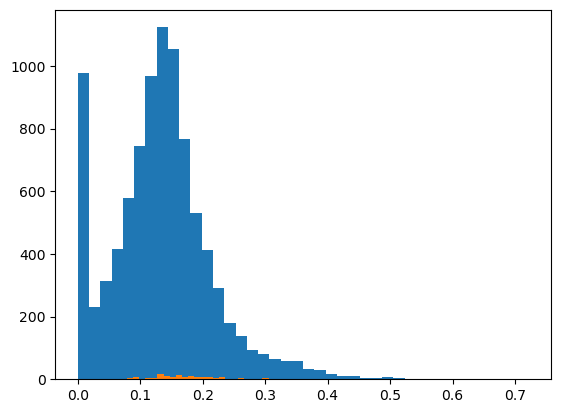

In [4]:
# plot the street ratio distribution of the dataset

custom_ratios = get_street_ratio_distr(custom_data["masks"])
original_ratios = get_street_ratio_distr(original_data["masks"])

plt.hist(custom_ratios,40)
plt.hist(original_ratios,40)
plt.show()

In [8]:

# create a dataset
custom_data_set = Sat_Mask_Dataset(custom_data["images"], custom_data["masks"],min_street_ratio=0.01)
original_data_set = Sat_Mask_Dataset(original_data["images"],original_data["masks"])
print(len(custom_data_set))

Initialzed dataset, checked for min,max street ratio. Discarded %: 0.09165942658557776  num discarded: 844
Initialzed dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
8364


In [ ]:
# make sure the dataset loading works as planned: 

import matplotlib.pyplot as plt

# get some random training images
idx = 0
image, mask = custom_data_set[idx]

img = np.array(image)
# swap first and third dimension
img = np.swapaxes(img, 0, 2)
mask = np.array(mask)
mask = np.swapaxes(mask, 0, 2)

# 1x2 plot: 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img)

# image + mask overlay
plt.subplot(1, 3, 2)
plt.title("Image + Mask")
plt.imshow(img + mask)

# mask
plt.subplot(1, 3, 3)
plt.title("Mask")
plt.imshow(mask)
plt.show()


print(img.min(), img.max(), mask.min(), mask.max())


## Dataloader

In [ ]:
train_split = 0.8
batch_size = 10


import torch.utils.data
custom_train_dataset, custom_test_dataset = torch.utils.data.random_split(custom_data_set, [train_split, 1-train_split])
original_train_dataset, original_test_dataset = torch.utils.data.random_split(original_data_set, [train_split, 1-train_split])


print(len(custom_train_dataset), len(custom_test_dataset))

from torch.utils.data import DataLoader


# CHECK IF THE FOR MULTIPLE NUM WORKERS THE CODE WORKS AS EXPECTED
# SEEMS TO BE CAUSING ISSUES WITH LONG startup and shutdown times for each epoch

train_dataloader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, drop_last=False,num_workers=0)
test_dataloader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=True, drop_last=False,num_workers=0)

In [ ]:
for image,mask in train_dataloader:
    print(image.shape, mask.shape)
    break

## Loading the model

In [ ]:

############ (CUSTOM SAM (stored in repo))
from custom_segment_anything.segment_anything import sam_model_registry
from custom_segment_anything.segment_anything.CUSTOM_SAM import *


sam_checkpoint_path = "custom_segment_anything/model_checkpoints/"

# base, large, huge checkpoints. 
checkpoints = ["sam_vit_b_01ec64.pth","sam_vit_l_0b3195.pth","sam_vit_h_4b8939.pth"]
checkpoint_names = ["vit_b","vit_l","vit_h"]

# 0,1,2 for base, large, huge checkpoints: 
checkpoint_idx = 0#,1,2

model_paths = [sam_checkpoint_path+checkpoint_name for checkpoint_name in checkpoints]


sam = sam_model_registry[checkpoint_names[checkpoint_idx]](checkpoint=model_paths[checkpoint_idx])
sam.to(device)
conv_decoder = Conv_Decoder()

model = SAM_Encoder_Custom_Decoder(sam.preprocess, sam.image_encoder,decoder=conv_decoder.decoder,encoder_finetune_num_last_layers=6)
model = model.to(device)

print(model)


## Training Loop

TODO:::

Note that right now the model is not using a sigmoid function in the last layer. 

implement the right loss function and test out different versions, add saving of the model version after training 

add evaluation of test dataloader to see prediction result. 

In [ ]:
# load the finetnued model state, if already started training. 

#finetune_path = "custom_segment_anything/model_checkpoints/finetuned/"
#name = "model_epoch3.pth"
# 
#model.load_state_dict(torch.load(finetune_path+name))


In [ ]:

print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

In [ ]:
import torch
import tqdm
from torcheval.metrics.functional import multiclass_f1_score

bce_loss = torch.nn.BCEWithLogitsLoss(reduction="sum")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15


for epoch in range(3,num_epochs):
    running_loss = 0.0
    i = 0
    for image, mask in train_dataloader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        # first steps of the model with no gradients
        
        x =model.sam_preprocess(image)
        x = model.sam_encoder(x)
        pred = model.decoder(x)
        
        #pred = model(image)

        # pred has shape (batch_size, 1, 1024, 1024)
        pred = pred[:,0,:,:] # [batch_size, 1024, 1024]
        # mask has shape (batch_size, 3, 1024, 1024)
        mask = mask[:,0,:,:] # [batch_size, 1024, 1024]

        # stretch the pred to one dimension
        loss = bce_loss(pred, mask)

        #loss = multiclass_f1_score(pred, mask,num_classes=2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(loss.item(),"step:",i,"of",len(train_dataloader))
        i += 1
    print(f"Epoch: {epoch}, Loss: {running_loss/len(train_dataset)}")

    if epoch % 2 == 0:
        # save the model
        torch.save(model.state_dict(), f"model_epoch{epoch}.pth")

# save the model
torch.save(model.state_dict(), "model_tr1.pth")
